### Import necessary modules

In [174]:
from pathlib import Path

DATASET = Path("../data/dataset-0.5.json")

MODEL = "ufal/robeczech-base"
BATCH_SIZE = 16

### Load data

Load dataset with errored sentences

In [175]:
from datasets import load_dataset

ds = load_dataset("json", data_files=str(DATASET))
ds_train = ds['train'].select(range(len(ds['train']) // 10))

dataset = ds_train.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'error', 'labels'],
        num_rows: 77513
    })
    test: Dataset({
        features: ['sentence', 'error', 'labels'],
        num_rows: 19379
    })
})

In [176]:
label_list = [0, 1]

### Load RoBERTa model tokenizer

Load Czech RoBERTa model tokenizer from huggingface

In [177]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained(MODEL, add_prefix_space=True)

### Examples how the data will be tokenized

In [178]:
example = dataset["train"][4]
example

{'sentence': ['DIK-1-1', '(', 'Selam', ')', '.'],
 'error': ['DIK-1-1', '(', '.Selam', ')', '.'],
 'labels': [0, 0, 1, 0, 0]}

In [179]:
tokenized_input = tokenizer(example["error"],  is_split_into_words=True)
tokenized_input

{'input_ids': [0, 19652, 143, 101, 174, 101, 174, 25, 5, 1416, 42577, 23, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [180]:
tokenized_input.tokens()

['[CLS]',
 'ĠDI',
 'K',
 '-',
 '1',
 '-',
 '1',
 'Ġ(',
 'Ġ.',
 'Se',
 'lam',
 'Ġ)',
 'Ġ.',
 '[SEP]']

In [181]:
tokenized_input.word_ids()

[None, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 4, None]

### Process dataset

Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from.

In [182]:
label_all_tokens = True

Define function that will preprocess our samples. We feed them to the tokenizer with the argument truncation=True (to truncate texts that are bigger than the maximum size allowed by the model) and is_split_into_words=True (as seen above). Then we align the labels with the token ids.

In [183]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["error"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128)

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [184]:
tokenize_and_align_labels(dataset['train'][:5])

{'input_ids': [[0, 87, 647, 2483, 1038, 28, 56, 212, 25340, 13, 5468, 3953, 35811, 434, 6787, 1147, 14, 32949, 131, 113, 1157, 897, 15, 3280, 4044, 18335, 434, 7064, 190, 262, 738, 4, 14, 24457, 12690, 25469, 996, 24099, 33060, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 21831, 20454, 31574, 310, 2142, 5660, 69, 354, 31, 10800, 2760, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 4555, 2102, 45741, 51, 5360, 482, 658, 6122, 132, 8305, 5415, 13, 80, 10778, 872, 1

In [185]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, num_proc=4)

Map (num_proc=4): 100%|██████████| 19379/19379 [00:00<00:00, 25635.30 examples/s]


### Fine-tuning the model

Now that our data is ready, we can download pretrained model and fine-tune it.

In [186]:
from transformers import RobertaForTokenClassification

# num labels should be 2 (valid and error)
model = RobertaForTokenClassification.from_pretrained(MODEL, num_labels=2)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We need to specify training arguments. It requires one folder name, which will be used to save the checkpoints of the model, others are optional.

In [187]:
from transformers import TrainingArguments

args = TrainingArguments(
    f"{MODEL}-finetuned-error-detection",
    evaluation_strategy="steps",
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
)

We will need a data collator that will batch our processed examples together while applying padding to make them all the same size (each pad will be padded to the length of its longest example). There is a data collator for this task in the Transformers library, that not only pads the inputs, but also the labels.

In [188]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our Trainer is how to compute the metrics from the predictions. Here we will use `classification_report`.

In [189]:
from sklearn.metrics import classification_report

So we will need to do a bit of post-processing on our predictions:

- select the predicted index (with the maximum logit) for each token
- convert it to its string label
- ignore everywhere we set a label of -100

In [190]:

import numpy as np

def compute_binary_classification_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

   # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]  # noqa: E741
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]  # noqa: E741
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten lists for easier processing
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]
    true_labels_flat = [item for sublist in true_labels for item in sublist]

    # Calculate metrics
    report = classification_report(true_labels_flat, true_predictions_flat, output_dict=True, zero_division=0)

    return {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }

We drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.

We just need to pass all of this along with our datasets to the `Trainer`.

In [191]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_binary_classification_metrics
)

/home/adam/projects/KNN/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [192]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.124600,0.077905,0.957908,0.941458,0.949456,0.975121
1000,0.081200,0.068354,0.974823,0.939015,0.955875,0.978712
1500,0.071000,0.065238,0.979402,0.934988,0.955600,0.978766
2000,0.067300,0.056687,0.978094,0.949682,0.963239,0.982119
2500,0.064100,0.056264,0.976678,0.952007,0.963852,0.982349
3000,0.061900,0.051287,0.977246,0.955690,0.966095,0.983389
3500,0.062100,0.053761,0.980739,0.953032,0.966273,0.983580
4000,0.058800,0.048446,0.975710,0.962842,0.969144,0.984744
4500,0.058500,0.050195,0.981297,0.954324,0.967231,0.984034
5000,0.050200,0.060500,0.981286,0.953310,0.966674,0.983779


   eval_loss  eval_precision  eval_recall   eval_f1  eval_accuracy  \
0   0.320126        0.423718     0.500000  0.458709       0.847435   
1   0.196053        0.924197     0.839698  0.874936       0.941609   
2   0.135422        0.923549     0.898695  0.910536       0.955081   
3   0.122777        0.940537     0.896344  0.916656       0.959033   
4   0.118107        0.948390     0.901144  0.922768       0.962135   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  step  
0        1.0619                  912.492                 57.443   0.08    20  
1        1.1001                  880.812                 55.448   0.16    40  
2        1.0903                  888.786                 55.950   0.25    60  
3        1.0975                  882.895                 55.580   0.33    80  
4        1.0965                  883.709                 55.631   0.41   100  


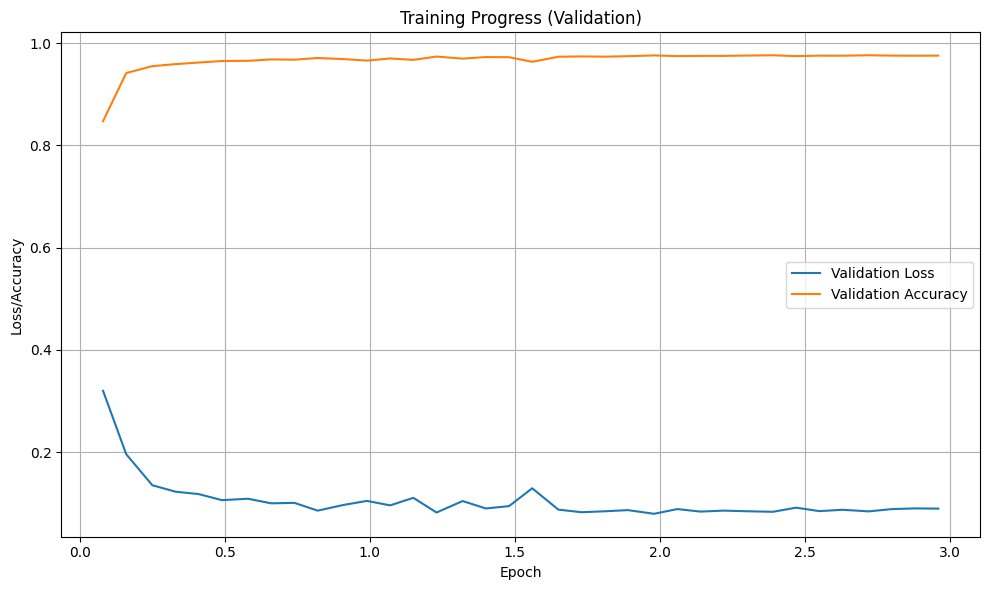

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_logs = [log for log in trainer.state.log_history if "eval_loss" in log]

df = pd.DataFrame(filtered_logs)

val_loss = df["eval_loss"]
val_accuracy = df["eval_accuracy"]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot validation loss (if available)
if val_loss[0] is not None:  # Check if data exists
    plt.plot(df["epoch"], val_loss, label="Validation Loss")

# Plot validation accuracy
plt.plot(df["epoch"], val_accuracy, label="Validation Accuracy")

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.title("Training Progress (Validation)")

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [ ]:
model.save_pretrained("./model/roberta-error-detection", from_pt=True)
tokenizer.save_pretrained("./model/roberta-error-detection", from_pt=True)

('./model/roberta-error-detection/tokenizer_config.json',
 './model/roberta-error-detection/special_tokens_map.json',
 './model/roberta-error-detection/vocab.json',
 './model/roberta-error-detection/merges.txt',
 './model/roberta-error-detection/added_tokens.json',
 './model/roberta-error-detection/tokenizer.json')